# PyTorch101 - Part 4 - MNIST Training
In this part, we are going to use the previously defined model to classify images from the MNIST dataset. We will use the easy dataloader provided by torchvision for this scope.

In [65]:
import matplotlib.pyplot as plt
from tqdm import tnrange, tqdm_notebook
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
print(torch.__version__)
print(torchvision.__version__)

0.4.0
0.2.1


We first start by downloading and preparing the dataset.

In [11]:
transform = transforms.Compose([
    # Space for other transformations
    transforms.ToTensor() # We need this to get a tensor instead of a PIL image
])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

We can also define data loaders for the datasets, specifying batch size, workers and shuffling

In [43]:
BATCH_SIZE = 4

trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

We can try displaying some of these images and labels to understand what is going on.

In [13]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

Process Process-4:
Process Process-3:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/nicom/anaconda/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/Users/nicom/anaconda/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/Users/nicom/anaconda/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/nicom/anaconda/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 52, in _worker_loop
    r = index_queue.get()
  File "/Users/nicom/anaconda/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/nicom/anaconda/lib/python3.6/multiprocessing/queues.py", line 343, in get
    res = self._reader.recv_bytes()
  File "/Users/nicom/anaconda/lib/python3.6/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxl

First label: tensor(4)
Image size: torch.Size([28, 28])


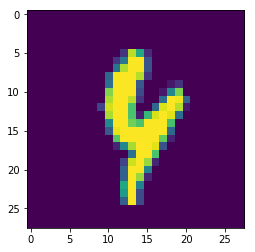

In [27]:
print("First label:", labels[1])
print("Image size:", images[0][0].size())
plt.imshow(images[1][0])
plt.show()

So, everything works as expected. 

Next, we replicate the network we defined in the previous part, also defining the Cross Entropy loss and the SGD optimizer.

In [32]:
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        # Define the network modules
        self.conv1 = nn.Conv2d(1, 32, 3) # input_filters=1 because MNIST is gray-scale
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.fc1 = nn.Linear(9216, 128) # 9216 is the size of the flattened layer
        self.fc2 = nn.Linear(128, 10)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        # Defines what happens in the forward pass
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(F.relu(self.conv2(x)),(2,2))
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        #x = self.softmax(x)
        return x
        
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

# Instantiate net
net = Net()
# Loss
criterion = nn.CrossEntropyLoss()
# Optimizer
optimizer = optim.SGD(net.parameters(), lr=0.001)

Now we have all the components we need for training: the data and the model. We will perform some epochs of the training, inspecting how the loss varies between epochs and batches.

In [45]:
EPOCHS = 2
LOG_STEP = 100

losses = []

for epoch in tnrange(EPOCHS):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in tqdm_notebook(enumerate(trainloader, 0), total=len(trainset)//BATCH_SIZE):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % LOG_STEP == LOG_STEP-1:
            losses.append(running_loss)
            running_loss = 0.0

HBox(children=(IntProgress(value=0, max=2), HTML(value='')))

HBox(children=(IntProgress(value=0, max=15000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=15000), HTML(value='')))

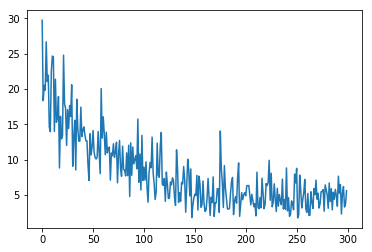

In [46]:
plt.plot(losses)
plt.show()

True labels: tensor([ 7,  2,  1,  0])



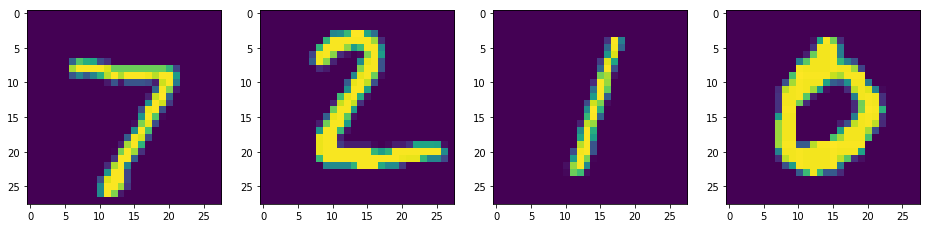

Predictions: [7 2 1 0]


In [77]:
dataiter = iter(testloader)
images, labels = dataiter.next()

print("True labels:", labels)
f, ax = plt.subplots(1, 4, figsize=(16,4))
for i in range(4):
    ax[i].imshow(images[i][0])
    
plt.show()

# Compute my prediction
outputs = net(images)
o = outputs.detach().numpy()
print("Predictions:", np.argmax(o, axis=1))

We just made a quick evaluation, but we could instead evaluate the whole test set to get an accuracy measure

In [78]:
accuracy = 0
for i, data in tqdm_notebook(enumerate(testloader, 0), total=len(testset)//BATCH_SIZE):
    inputs, labels = data
    outputs = net(inputs)
    o = outputs.detach().numpy()
    predictions = np.argmax(o, axis=1)
    # Add to accumulator
    accuracy += np.equal(predictions, labels).sum().item()

accuracy = accuracy / len(testset)
print("Final accuracy:", accuracy)

HBox(children=(IntProgress(value=0, max=2500), HTML(value='')))

Final accuracy: 0.9814


So, our model performs quite well on the test set!

Before moving on to the next part, where we remotely train on a GPU this model, I want to try the visualization of the training process. PyTorch does not have a "built-in" visualization tool like tensorboard, but using this package, [Tensorboard-Pytorch](https://github.com/lanpa/tensorboard-pytorch), we can use tensorboard itself with pytorch.

In [81]:
from tensorboardX import SummaryWriter

from time import sleep

writer = SummaryWriter()

for i in range(100):
    dummy_s1 = torch.rand(1)
    writer.add_scalar('data/scalar1', dummy_s1[0], i)
    writer.add_scalar('data/sinx', np.sin(i), i)
    sleep(0.5)

# export scalar data to JSON for external processing
#writer.export_scalars_to_json("./all_scalars.json")
writer.close()

The log gets written in the 'runs' directory. Tensorboard-pytorch also implements different data types: histograms, images, audios etc.


The next screenshot shows the output for the previous code.

![Tensorboard output](img/tensorboardX.png)